# <div align="center"> COSC 2673/2793 | Machine Learning </div>

## <div align="center"> Assignment 2 - Joseph Packham (s3838978) and Kylie Nguyen (s3946026) </div>


# Introduction

This report will cover the process of producing a machine learning model that will predict energy usage...


In [79]:
# importing packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pydot as pyd
from tensorflow.keras.metrics import MeanAbsoluteError
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout, BatchNormalization

In [ ]:
# read in CSV file and display first 5 rows
energyUse_df = pd.read_csv("./dataset/UCI-electricity/UCI_data.csv", delimiter=",")
energyUse_df.head()

# Exploratory Data Analysis

First, the data is investigated through EDA. It is observed that the shape of the dataframe is 19735 rows of data with 28 columns, where 1 column is the target variable (energy usage in Wh), and the remaining columns are the attributes. According to the description of the data, these attributes cover the temperature and humidity of different rooms in the house, as well as outside, along with a few other weather related variables such as pressure and windspeed. It is noted that there are two variables listed as "Random Variable". Using the .info() function, it is confirmed that there are no null values within the dataset.


In [86]:
# check for any null values, using shape to compare
print("Shape of Energy Use dataframe: ", energyUse_df.shape, "\n")

energyUse_df.info()

Shape of Energy Use dataframe:  (19735, 28) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           19735 non-null  object 
 1   T1             19735 non-null  float64
 2   RH_1           19735 non-null  float64
 3   T2             19735 non-null  float64
 4   RH_2           19735 non-null  float64
 5   T3             19735 non-null  float64
 6   RH_3           19735 non-null  float64
 7   T4             19735 non-null  float64
 8   RH_4           19735 non-null  float64
 9   T5             19735 non-null  float64
 10  RH_5           19735 non-null  float64
 11  T6             19735 non-null  float64
 12  RH_6           19735 non-null  float64
 13  T7             19735 non-null  float64
 14  RH_7           19735 non-null  float64
 15  T8             19735 non-null  float64
 16  RH_8           19735 non-null  float64
 17  T9  

Using the describe function, the count, mean, standard deviation, quantiles and the minimum and maximum values of the data are returned. With these values it is seen that, although the range of the values among the variables regarding humidity and temperature are relatively similar, there are cases where the range differs greatly. For example, the range of Windspeed is between 0-14, whereas the range of target energy is between 10-1110. This suggests that feature scaling should be done later in the process, as the differing ranges may cause problems or confuse the learning algorithms.


In [87]:
energyUse_df.describe()

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,...,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033,101.496833
std,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,...,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634,104.380829
min,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,...,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,10.000000
25%,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,...,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889,50.000000
50%,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,...,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653,60.000000
75%,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,...,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769,100.000000
max,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,...,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530,1110.000000


# Data distribution

In order to observe the distributions of each variable, histograms are plotted for the variables other than date, as the date variable is of type object and cannot be plotted.


In [ ]:
# get list of columns other than date
columns = (energyUse_df.columns).difference(["date"])
# plot histogram for all variables other than date
plt.figure(figsize=(20, 20))
for i, column in enumerate(columns):
    plt.subplot(6, 5, i + 1)
    plt.hist(energyUse_df[column], alpha=0.3, color="b", density=True)
    plt.title(column)
    plt.xticks(rotation="vertical")
    plt.tight_layout()

> **Observations:**
>
> - There are a number of attributes that appear to be skewed, eg. RH_5, RH_Out, T2 etc.
> - The two random variables are very evenly distributed.


In [ ]:
# display boxplot for the target, energy usage, variable
plt.boxplot(energyUse_df["TARGET_energy"])
plt.title("Energy Usage")
plt.show()

After displaying the boxplot for the target variable, it is observed that there are a number of outliers above the lower limit. These values will be dropped as to prevent these dramatically different values from affecting the model. The outliers are dropped using the IQR method.


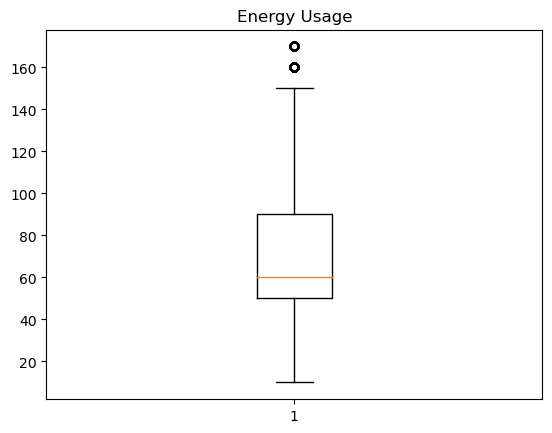

In [88]:
# get the quantiles and IQR
q1 = energyUse_df["TARGET_energy"].quantile(0.25)
q3 = energyUse_df["TARGET_energy"].quantile(0.75)
IQR = q3 - q1

# calculate lower and upper limits
lowerLimit = q1 - (1.5 * IQR)
upperLimit = q3 + (1.5 * IQR)

# get rid of rows with outliers from the dataframe
energyUse_df = energyUse_df.loc[
    (energyUse_df["TARGET_energy"] > lowerLimit)
    & (energyUse_df["TARGET_energy"] < upperLimit)
]

# display boxplot without outliers
plt.boxplot(energyUse_df["TARGET_energy"])
plt.title("Energy Usage")
plt.show()

In [ ]:
energyUse_df.shape

# Relationship between variables

Using scatterplots, the relationship between the target variable, Energy Usage, against the other attributes in the dataframe is explored.


In [ ]:
# import seaborn package for plotting scatterplots
import seaborn as sns

# plot scatterplots for all features against target variable
plt.figure(figsize=(20, 20))
for i, column in enumerate(columns):
    plt.subplot(6, 5, i + 1)
    sns.scatterplot(data=energyUse_df, x=column, y="TARGET_energy")
    plt.title(column)

plt.xticks(rotation="vertical")
plt.tight_layout()
plt.show()

In [ ]:
# get list of columns other than date and target
columns = (energyUse_df.columns).difference(["date", "TARGET_energy"])

g = sns.PairGrid(data=energyUse_df, vars=columns, hue="TARGET_energy")
g.map(sns.scatterplot)
plt.show()

> **Observations:**
>
> - There are some plots that show that a linear decision boundary may be able to separate the two classes. eg.
> - Whereas there are some plots that show that a non-linear decision boundary may be to separate the two classes.


In [ ]:
# get df without date column
energyUse_df_noDate = energyUse_df.drop(columns=["date"])

# plot correlation plot
f, ax = plt.subplots(figsize=(11, 9))
corr = energyUse_df_noDate.corr()
ax = sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment="right")

> **Observations:**
>
> - Variables relating to temperature are highly positively correlated with each other, and variables that are related to humidity are similarly, highly positively correlated with each other.
> - Variables involving temperature generally have either a slight positive, or slight negative correlation with variables involving humidity.
> - RH_6, the humidity outside the building (northside) seems to be quite negatively correlated with variables regarding temperature.
> - The two random variables do not seem to be correlated with any other variable other being highly correlated with themselves as well as each other.


In [ ]:
energyUse_df["TARGET_energy"].hist(figsize=(5, 5))
plt.xlabel("Energy Usage")
plt.ylabel("frequency")
plt.show()

# Creating Neural Network


In [ ]:
# function to plot learning curve
def plot_learning_curve(
    train_loss, val_loss, train_metric, val_metric, metric_name="MeanAbsoluteError"
):

    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, "r--")
    plt.plot(val_loss, "b--")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(["train", "val"], loc="upper left")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_metric, "r--")
    plt.plot(val_metric, "b--")
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(["train", "val"], loc="upper left")

    plt.show()

In [89]:
# split the data into traing, testing and validation

with pd.option_context("mode.chained_assignment", None):
    train_data, test_data = train_test_split(
        energyUse_df, test_size=0.3, shuffle=True, random_state=42
    )
    test_data, val_data = train_test_split(
        test_data, test_size=0.5, shuffle=True, random_state=42
    )

# remove the target column from the data
X_train = train_data.drop(columns=["TARGET_energy", "date"])
y_train = train_data["TARGET_energy"]

X_test = test_data.drop(columns=["TARGET_energy", "date"])
y_test = test_data["TARGET_energy"]

X_val = val_data.drop(columns=["TARGET_energy", "date"])
y_val = val_data["TARGET_energy"]

# train data - used to train the model
# validation data - used to tune the hyperparameters
# test data - used to evaluate the final model

# print the shapes of the data
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (12267, 26)
y_train shape:  (12267,)
X_val shape:  (2629, 26)
y_val shape:  (2629,)
X_test shape:  (2629, 26)
y_test shape:  (2629,)


## Base Neural Network on unchanged Data


In [ ]:
# base model values
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 256  # this can be tuned later
OUTPUT_CLASSES = 1

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation="relu"),
        tf.keras.layers.Dense(OUTPUT_CLASSES, activation="linear"),
    ]
)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

# compile model
model.compile(
    optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]
)

# train the model
history = model.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1
)

In [ ]:
plot_learning_curve(
    history.history["loss"],
    history.history["val_loss"],
    history.history["mean_absolute_error"],
    history.history["val_mean_absolute_error"],
)

# evaluate the model
val_loss, val_mae = model.evaluate(X_val, y_val)
print("Validation loss: ", val_loss)
print("Validation MAE: ", val_mae)

#### Observations

- the model performs extremely poorly
- neds significant improvement
  -over fitting is a major issue


In [90]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [ ]:

model2 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation="relu"),
        tf.keras.layers.Dense(OUTPUT_CLASSES),
    ]
)

model2.summary()
tf.keras.utils.plot_model(model2, show_shapes=True)


# compile model
model2.compile(
    optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]
)

# train the model
history2 = model2.fit(
    X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=50, verbose=1
)

In [ ]:
# plot graph
plot_learning_curve(
    history2.history["loss"],
    history2.history["val_loss"],
    history2.history["mean_absolute_error"],
    history2.history["val_mean_absolute_error"],
)

# evaluate the model
val_loss, val_mae = model2.evaluate(X_val_scaled, y_val)
print("Validation loss: ", val_loss)
print("Validation MAE: ", val_mae)

- still seems to be overfitting possibly


In [ ]:
# change batchsize

INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 256  # this can be tuned later
OUTPUT_CLASSES = 1
BATCH_SIZE = 64

# create model
model3 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation="relu"),
        tf.keras.layers.Dense(OUTPUT_CLASSES),
    ]
)

# compile model
model3.compile(
    optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]
)

# train the model
history3 = model3.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    verbose=1,
    batch_size=BATCH_SIZE,
)

In [ ]:
# plot learning curve
plot_learning_curve(
    history3.history["loss"],
    history3.history["val_loss"],
    history3.history["mean_absolute_error"],
    history3.history["val_mean_absolute_error"],
)

# evaluate the model
val_loss, val_mae = model3.evaluate(X_val_scaled, y_val)

In [ ]:
# change batch size
BATCH_SIZE = 256

# fit model
history4 = model3.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    verbose=1,
    batch_size=BATCH_SIZE,
)

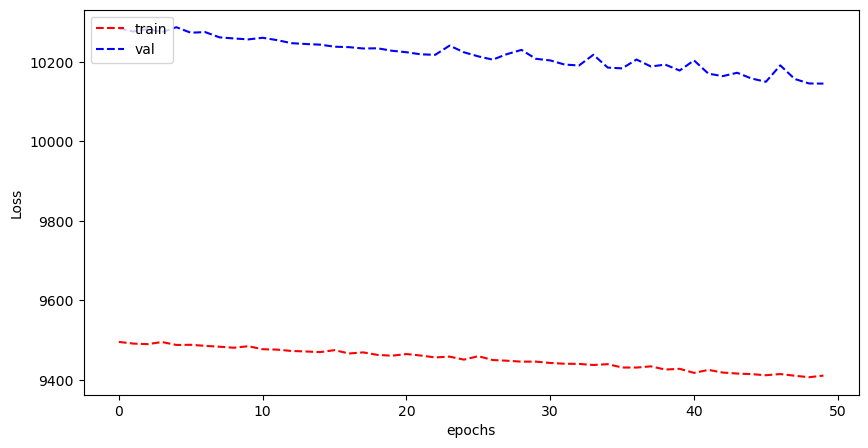

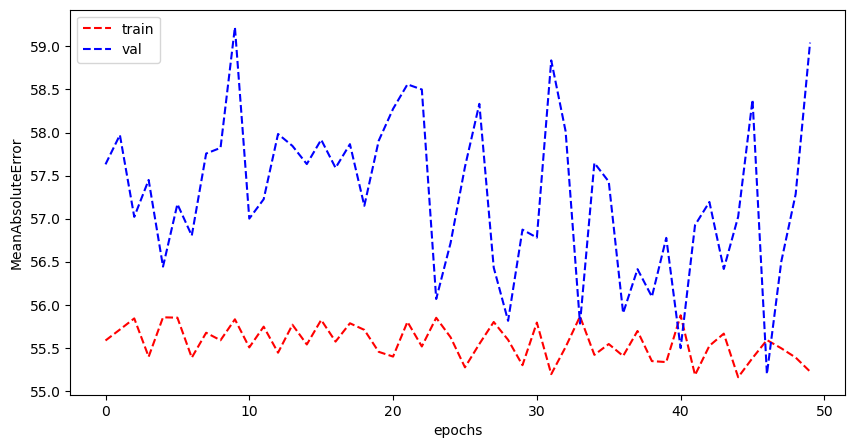

93/93 [==============================] - 0s 957us/step - loss: 10145.6182 - mean_absolute_error: 59.0435


In [40]:
# plot learning curve
plot_learning_curve(
    history4.history["loss"],
    history4.history["val_loss"],
    history4.history["mean_absolute_error"],
    history4.history["val_mean_absolute_error"],
)

# evaluate the model
val_loss, val_mae = model3.evaluate(X_val_scaled, y_val)

Model is overfitting


In [58]:
# try regularisation
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512  # this can be tuned later
OUTPUT_CLASSES = 1
BATCH_SIZE = 128

# create model
model4 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l1(0.01),
        ),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model4.compile(
    optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]
)

# train the model
history5 = model4.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    verbose=1,
    batch_size=BATCH_SIZE,
)

Epoch 1/50
108/108 [==============================] - 1s 3ms/step - loss: 17089.2734 - mean_absolute_error: 79.6460 - val_loss: 14844.2607 - val_mean_absolute_error: 63.0612
Epoch 2/50
108/108 [==============================] - 0s 2ms/step - loss: 12054.1992 - mean_absolute_error: 60.1702 - val_loss: 12559.8018 - val_mean_absolute_error: 62.5762
Epoch 3/50
108/108 [==============================] - 0s 2ms/step - loss: 11080.7422 - mean_absolute_error: 60.2108 - val_loss: 11859.4268 - val_mean_absolute_error: 61.3674
Epoch 4/50
108/108 [==============================] - 0s 2ms/step - loss: 10567.7275 - mean_absolute_error: 58.3169 - val_loss: 11309.6279 - val_mean_absolute_error: 60.2685
Epoch 5/50
108/108 [==============================] - 0s 2ms/step - loss: 10163.1445 - mean_absolute_error: 57.6585 - val_loss: 10869.3213 - val_mean_absolute_error: 58.4010
Epoch 6/50
108/108 [==============================] - 0s 2ms/step - loss: 9859.3379 - mean_absolute_error: 56.2504 - val_loss: 105

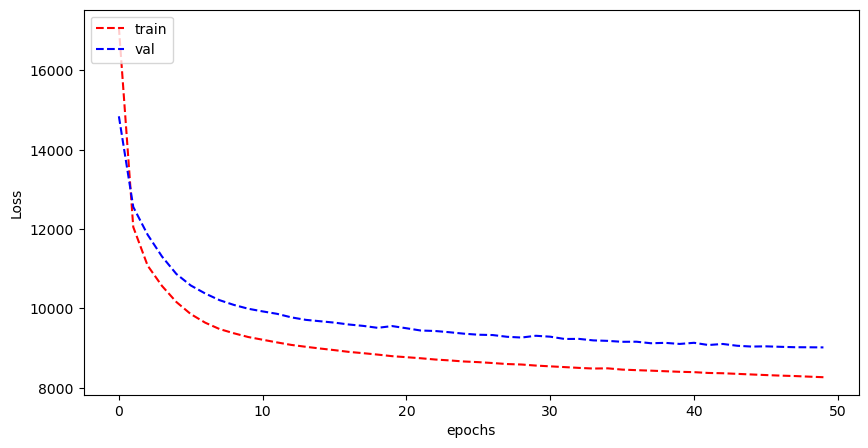

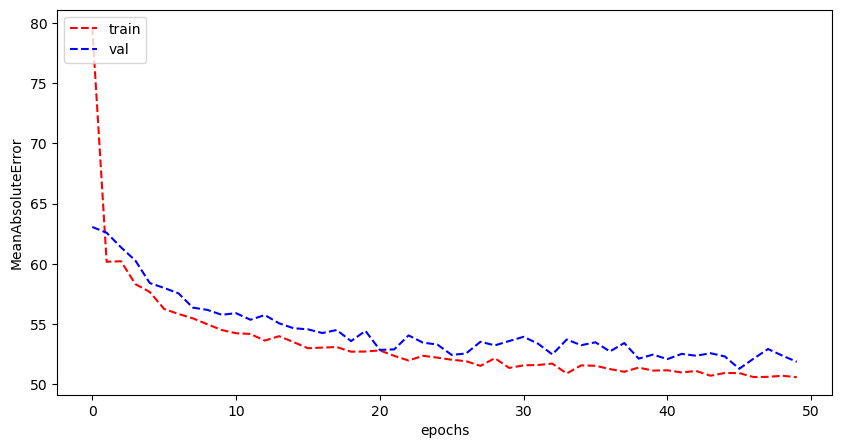

93/93 [==============================] - 0s 1ms/step - loss: 9019.5557 - mean_absolute_error: 51.8623


In [59]:
# plot learning curve
plot_learning_curve(
    history5.history["loss"],
    history5.history["val_loss"],
    history5.history["mean_absolute_error"],
    history5.history["val_mean_absolute_error"],
)

# evaluate the model
val_loss, val_mae = model4.evaluate(X_val_scaled, y_val)

- still overfitting the model   
-standard scaler is working better than minmax scaler

In [91]:
# tune regularisation
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512  # this can be tuned later
OUTPUT_CLASSES = 1
BATCH_SIZE = 128
REGULARIZATIONFACTOR = 5

# create model
model5 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model5.compile(
    optimizer="adam",
    loss='mean_squared_error',
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history6 = model5.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    verbose=1,
    batch_size=BATCH_SIZE,
)

Epoch 1/50
96/96 [==============================] - 1s 4ms/step - loss: 8120.7798 - mean_absolute_error: 55.2940 - root_mean_squared_error: 63.8746 - val_loss: 5750.0776 - val_mean_absolute_error: 40.1171 - val_root_mean_squared_error: 49.9395
Epoch 2/50
96/96 [==============================] - 0s 2ms/step - loss: 4611.7808 - mean_absolute_error: 33.1642 - root_mean_squared_error: 43.8911 - val_loss: 3514.0056 - val_mean_absolute_error: 27.6971 - val_root_mean_squared_error: 37.2820
Epoch 3/50
96/96 [==============================] - 0s 2ms/step - loss: 2978.1572 - mean_absolute_error: 26.5500 - root_mean_squared_error: 36.0754 - val_loss: 2355.9390 - val_mean_absolute_error: 23.9206 - val_root_mean_squared_error: 32.7498
Epoch 4/50
96/96 [==============================] - 0s 2ms/step - loss: 2031.2001 - mean_absolute_error: 23.1855 - root_mean_squared_error: 31.9091 - val_loss: 1635.9751 - val_mean_absolute_error: 21.2477 - val_root_mean_squared_error: 29.4650
Epoch 5/50
96/96 [======

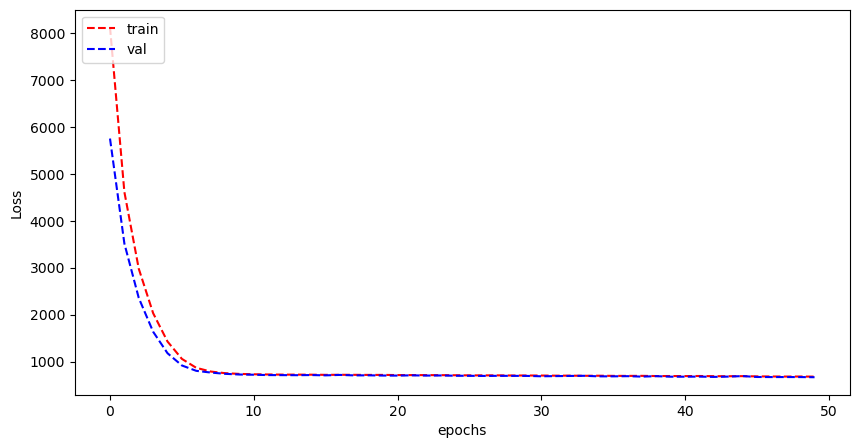

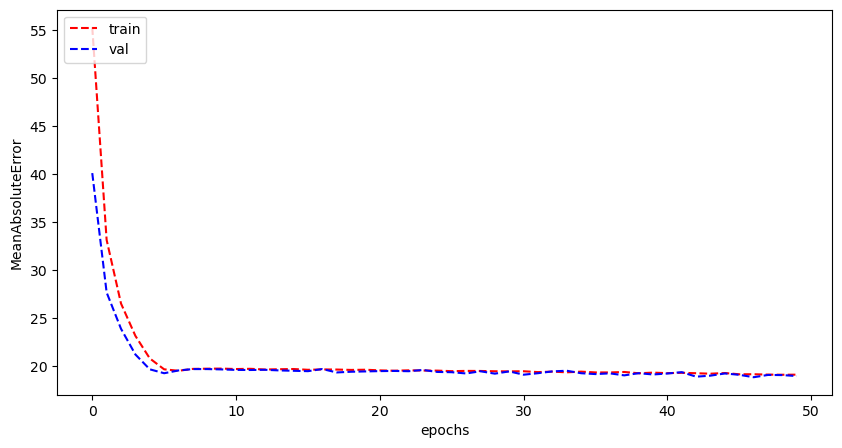

83/83 [==============================] - 0s 1ms/step - loss: 667.8136 - mean_absolute_error: 19.0048 - root_mean_squared_error: 25.1497


ValueError: too many values to unpack (expected 2)

In [94]:
# plot learning curve
plot_learning_curve(
    history6.history["loss"],
    history6.history["val_loss"],
    history6.history["mean_absolute_error"],
    history6.history["val_mean_absolute_error"],
)

# evaluate the model
val_loss, val_mae = model5.evaluate(X_val_scaled, y_val)

- not greatv still but no more overfitting 

In [95]:
# tune regularisation
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 256  # this can be tuned later
OUTPUT_CLASSES = 1
BATCH_SIZE = 64
REGULARIZATIONFACTOR = 0.01

# create model
model6 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(0.5),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model6.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history7 = model6.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    verbose=1,
    batch_size=BATCH_SIZE,
)

Epoch 1/50
192/192 [==============================] - 1s 4ms/step - loss: 5133.6343 - mean_absolute_error: 65.3006 - root_mean_squared_error: 71.6133 - val_loss: 3727.8840 - val_mean_absolute_error: 54.7063 - val_root_mean_squared_error: 61.0143
Epoch 2/50
192/192 [==============================] - 0s 2ms/step - loss: 2031.0715 - mean_absolute_error: 36.3882 - root_mean_squared_error: 45.0104 - val_loss: 848.2684 - val_mean_absolute_error: 21.1779 - val_root_mean_squared_error: 29.0369
Epoch 3/50
192/192 [==============================] - 0s 2ms/step - loss: 698.4833 - mean_absolute_error: 19.3947 - root_mean_squared_error: 26.3317 - val_loss: 598.8906 - val_mean_absolute_error: 17.9540 - val_root_mean_squared_error: 24.3673
Epoch 4/50
192/192 [==============================] - 0s 2ms/step - loss: 630.1516 - mean_absolute_error: 18.7895 - root_mean_squared_error: 25.0006 - val_loss: 579.0838 - val_mean_absolute_error: 17.6659 - val_root_mean_squared_error: 23.9576
Epoch 5/50
192/192 [=

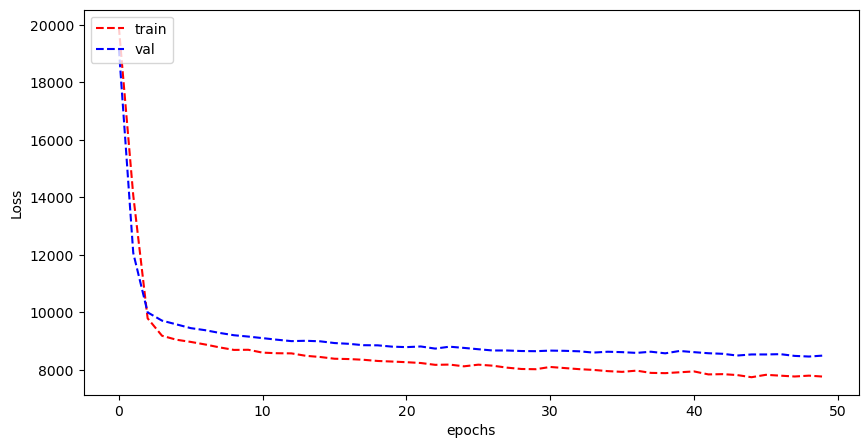

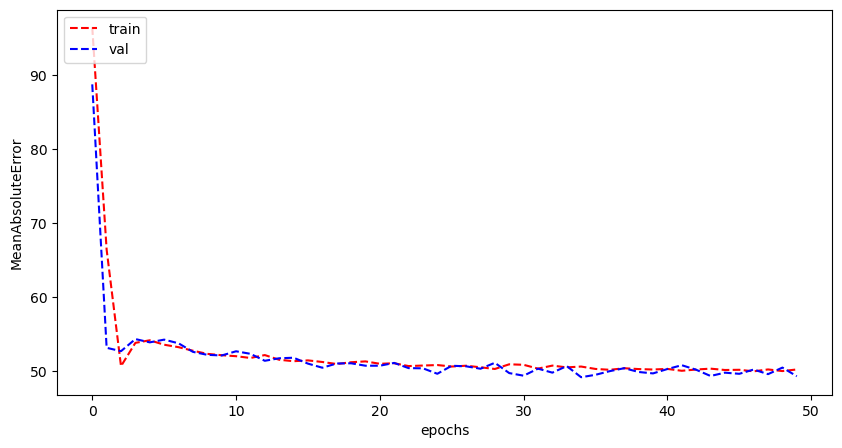

In [85]:
# plot learning curve
plot_learning_curve(
    history7.history["loss"],
    history7.history["val_loss"],
    history7.history["mean_absolute_error"],
    history7.history["val_mean_absolute_error"],
)

- performing not well but better thasn the start
- will try creatting features to represent the time series data